# Line Spectra Estimation

Line spectral estimation seeks to
accurately recover the frequencies and amplitudes
of a signal $\mathbf{y} \in \mathbb{R}^{n}$ which consists
of a mixture of $N$ sinusoids.

Firstly the signal $\mathbf{y}$ can be generated:

In [1]:
srand(39)

Fs = 16e3 #sampling frequency
n = 2^7 #time samples
y0 = zeros(n)
SNR = 20

s = 4 #super-resolution factor
f_s  = linspace(0,  Fs,       s*n+1)[1:end-1]     # super resolution frequency axis
f_s2 = linspace(0,Fs/2,div(s*n,2)+1)              # super resolution frequency axis (up to Nyquist)
f  = linspace(0,Fs,n+1)[1:end-1]                 # frequency axis
f2 = linspace(0,Fs/2,div(n,2)+1)                 # frequency axis (up to Nyquist)
t  = 0:1/Fs:(n-1)/Fs                              # time axis

N = 14                                             # number of sinusoids

fk = f_s2[randperm(div(s*n,4)+1)[1:N]]             # sinusoids frequencies
ak = 0.1*randn(N)+0.7                              # amplitude

for i in eachindex(fk) y0 .+= ak[i].*sin.(2*π*fk[i].*t) end # mixture of sinusoids
y = y0.+10^(-SNR/10)*sqrt(var(y0))*randn(length(y0)); # add noise



A simple solution to estimate the frequencies is to
take the DFT or the zero-padded DFT of $\mathbf{y}$ 
where $s$ is the super-resolution factor.
However, as the following figure shows,
spectral leakage causes components at
close frequencies to merge.



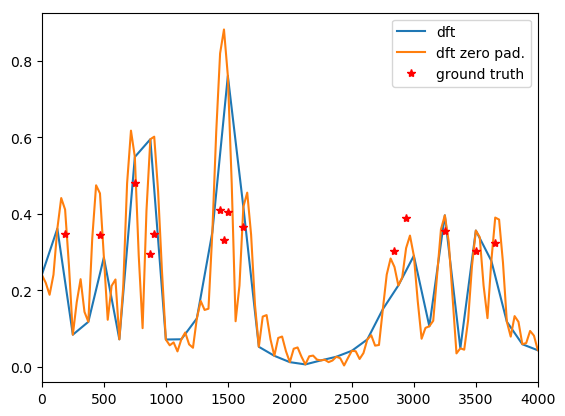

In [2]:
xzp = fft([y;zeros((s-1)*length(y))]) #zero padded signal

using PyPlot
figure()
plot(f,abs.(fft(y)./n ), label = "dft")
plot(f_s,abs.(xzp./n ), label = "dft zero pad.")
plot(fk,abs.(ak)/2     , "r*", label = "ground truth")
xlim([0;Fs/4])
legend();



This issue is not present if the following optimization problem
is solved (LASSO):

$$ \mathbf{x}_1^{\star} = \underset{\mathbf{x}}{\text{argmin}} \tfrac{1}{2} \| S F^{-1} \mathbf{x} -\mathbf{y} \|^2 + \lambda \| \mathbf{x} \|_1,  $$

where $S$ is a selection mapping and $F^{-1}$ the inverse DFT. 


In [3]:
using StructuredOptimization

x = Variable(Complex{Float64}, s*n) # define complex-valued variable
lambda = 1e-3*norm(xzp./(s*n),Inf)  # set lambda

@minimize ls(ifft(x)[1:n]-y)+lambda*norm(x,1) with PANOC(tol = 1e-8);
x1 = copy(~x); # copy solution

    it |      gamma |        fpr |        tau |        FBE |
 ------|------------|------------|------------|------------|
     1 | 4.8640e+02 | 1.1183e-02 | 1.0000e+00 | 1.6652e+00 | 
   100 | 4.8640e+02 | 3.4660e-04 | 1.0000e+00 | 1.1605e+00 | 
   200 | 4.8640e+02 | 6.6716e-05 | 1.0000e+00 | 1.1245e+00 | 
   300 | 4.8640e+02 | 2.1481e-05 | 1.0000e+00 | 1.1201e+00 | 
   400 | 4.8640e+02 | 2.1729e-05 | 1.0000e+00 | 1.1199e+00 | 
   500 | 4.8640e+02 | 1.2903e-05 | 1.0000e+00 | 1.1198e+00 | 
   600 | 4.8640e+02 | 8.4105e-06 | 1.0000e+00 | 1.1197e+00 | 
   700 | 4.8640e+02 | 5.0657e-06 | 1.0000e+00 | 1.1197e+00 | 
   800 | 4.8640e+02 | 8.2936e-07 | 1.0000e+00 | 1.1197e+00 | 
   900 | 4.8640e+02 | 8.6857e-07 | 1.0000e+00 | 1.1197e+00 | 
  1000 | 4.8640e+02 | 3.5925e-07 | 1.0000e+00 | 1.1197e+00 | 
  1100 | 4.8640e+02 | 3.3134e-08 | 1.0000e+00 | 1.1197e+00 | 
  1177 | 4.8640e+02 | 8.8470e-09 | 1.0000e+00 | 1.1197e+00 | 



The obtained solution $\mathbf{x}_1^{\star}$ is considerably more precise than before. However spurious frequencies are present and the amplitude of the frequencies is usually underestimated.


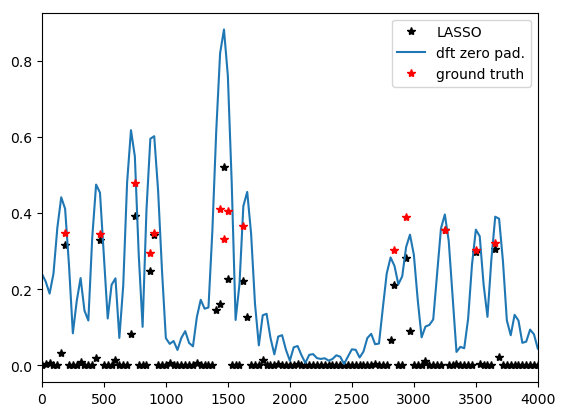

In [4]:
figure()
plot(f_s,abs.(x1./(s*n) ), "k*", label = "LASSO")
plot(f_s,abs.(xzp./n ), label = "dft zero pad.")
plot(fk,abs.(ak)/2, "r*", label = "ground truth")
xlim([0;Fs/4])
legend();

It is actually possible to refine this solution by solving the nonconvex problem:

$$ \mathbf{x}_0^{\star} = \underset{\mathbf{x}}{\text{argmin}} \tfrac{1}{2} \| S F^{-1} \mathbf{x} -\mathbf{y} \|^2  \ \text{s.t.} \ \| \mathbf{x} \|_0 \leq 2 N. $$

In [5]:
@minimize ls(ifft(x)[1:n]-y) st norm(x,0) <= 2*N  with PANOC(tol = 1e-8);
x0 = copy(~x);

    it |      gamma |        fpr |        tau |        FBE |
 ------|------------|------------|------------|------------|
     1 | 4.8640e+02 | 3.1927e-02 | 1.0000e+00 | 6.9309e+00 | 
    92 | 4.8640e+02 | 8.4988e-09 | 1.0000e+00 | 2.2448e-02 | 



Almost a perfect reconstruction is achieved by solving this nonconvex problem. It is important to notice that this was possible because the problem was initialized with the LASSO solution and a _good_ local minimum was reached.


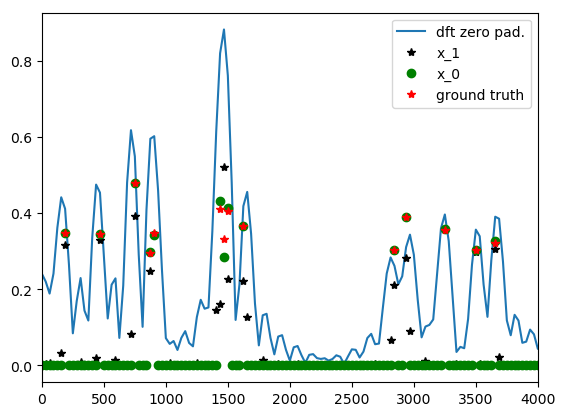

In [6]:
figure()
plot(f_s,abs.(xzp./n ), label = "dft zero pad.")
plot(f_s,abs.(x1./(s*n)), "k*", label = "x_1")
plot(f_s,abs.(x0./(s*n)), "go", label = "x_0")
plot(fk,abs.(ak)/2, "r*", label = "ground truth")
xlim([0;Fs/4])
legend();